# Group trips analysys 

In this presentation we are trying finding dependence in number of group trips, and identifying the most popular routes and station of group trips.

Setup:

In [3]:
import pandas as pd
import numpy as np

import datetime 
from datetime import timedelta

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Starting with preparing data with converting `starttime` and `stoptime` to `datetime` format and dropping unnecessary columns.

In [4]:
def prepare_data(filename):
    df = pd.read_csv(filename)

    df = df.drop(df.index[(df['tripduration'] > 7200)])
    df = df.drop(df.index[(df['start station id'] == df['end station id'])])
    df = df[(df['birth year'] < 2000) & (df['birth year'] > 1970)]

    df["start station id"]= df["start station id"].astype(int) 
    df["end station id"]= df["end station id"].astype(int) 
    df["starttime"]= pd.to_datetime(df["starttime"], format="%Y-%m-%d %H:%M:%S.%f")
    df["stoptime"] = pd.to_datetime(df["stoptime"], format="%Y-%m-%d %H:%M:%S.%f")


    df.drop(['tripduration', 'usertype', 'start station latitude', 'start station longitude', 'end station longitude', 'end station latitude', 'birth year', 'gender', 'bikeid'], axis=1, inplace=True)
    return df 

This is the main logic of this analysys. We took assumption that group ride is a ride with more then two people, who are renting and returning bikes at the almost same time (`max difference` = 5 minutes) and taking the same route.

In the code below firstly we grouping records by `starttime` delta assigning to them `group id`, then doing the same thing for `endtime`. Finally we are just grouping all records by `start_group_id`, `end_group_id`, `start station name` and `end station name`. Finall step we are taking is dropping all group rides with less then two people in a group.

In [5]:
def detect_groups(df):
    # start time id
    sorted_by_time = df.sort_values(by=['starttime'])

    sorted_by_time.insert(1, "diff_start", sorted_by_time['starttime'].diff(), True)
    sorted_by_time.insert(1, "id_start", None, True) 


    group_id = 0
    for idx, r in sorted_by_time.iterrows():
        if r.diff_start > datetime.timedelta(minutes=5):
            group_id+=1
        sorted_by_time['id_start'][idx] = group_id


    # end time id
    sorted_by_time = sorted_by_time.sort_values(by=['stoptime'])

    sorted_by_time.insert(1, "diff_end", sorted_by_time['stoptime'].diff(), True) 
    sorted_by_time.insert(1, "id_end", None, True) 


    group_id = 0
    for idx, r in sorted_by_time.iterrows():
        if r.diff_end > datetime.timedelta(minutes=5):
            group_id+=1
        sorted_by_time['id_end'][idx] = group_id


    sorted_by_time.insert(1, 'group_id', sorted_by_time.groupby(['start station name', 'end station name', 'id_start', 'id_end']).ngroup(), True)

    #dropping all groups with less than 2 people
    groups = sorted_by_time[sorted_by_time.duplicated(subset=['group_id'], keep=False)]
    
    return groups

Taking data from the last 12 month:

In [6]:
year_datafiles = {
                "Jun'19": 'datasets/JC-201906-citibike-tripdata.csv',
                  "Jul'19": 'datasets/JC-201907-citibike-tripdata.csv',
                  "Aug'19": 'datasets/JC-201908-citibike-tripdata.csv',
                  "Sep'19": 'datasets/JC-201909-citibike-tripdata.csv',
                  "Oct'19": 'datasets/JC-201910-citibike-tripdata.csv',
                  "Nov'19": 'datasets/JC-201911-citibike-tripdata.csv',
                  "Dec'19": 'datasets/JC-201912-citibike-tripdata.csv',
                  "Jan'20": 'datasets/JC-202001-citibike-tripdata.csv',
                  "Feb'20": 'datasets/JC-202002-citibike-tripdata.csv',
                  "Mar'20": 'datasets/JC-202003-citibike-tripdata.csv',
                  "Apr'20": 'datasets/JC-202004-citibike-tripdata.csv', 
                  "May'20": 'datasets/JC-202005-citibike-tripdata.csv'
               }

For each file from `year_datafiles` dataset we are calculating number of group rides. 

In [7]:
year_report = pd.DataFrame(columns = ['month', 'group_trips'])

for n, f in year_datafiles.items():
    df = prepare_data(f)
    groups = detect_groups(df)
    year_report = year_report.append({'month':n, 'group_trips': groups.group_id.nunique()}, ignore_index=True)

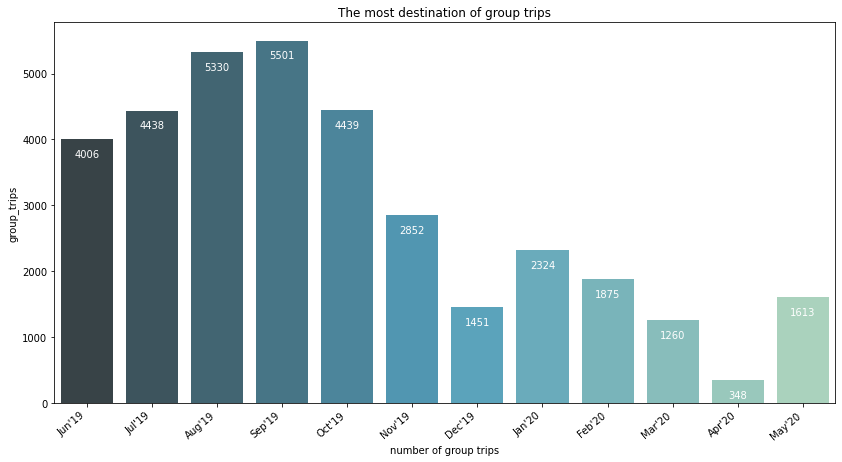

In [13]:
ax = sns.barplot(year_report['month'], year_report['group_trips'], palette="GnBu_d")
ax.set_title('The most destination of group trips', fontsize = 12)
ax.set(xlabel='number of group trips')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha = 'right')

rcParams['figure.figsize'] = 16,7

padding = 0.05 * year_report.group_trips.max()
for index, c in enumerate(year_report.group_trips):
    ax.text(index,c - padding, round(c, 1), 
            color='white', ha="center", fontsize = 10)

plt.show()

You can see very interesting observation: with the begining of coronavirus number of group rides strongly decreasted, especially in April, when most of the countries provided quarantine mode. Our statistic giving a proof to popular opinion that now more and more people taking precautionary measures less seriously - in May numbers increased almost in 5 times.

Let's analyze group trips from another side. Let's checkout most popular routes groups of people love to take.

In [9]:
filename = 'datasets/JC-201907-citibike-tripdata.csv'

In [10]:
df = prepare_data(filename)
groups = detect_groups(df)

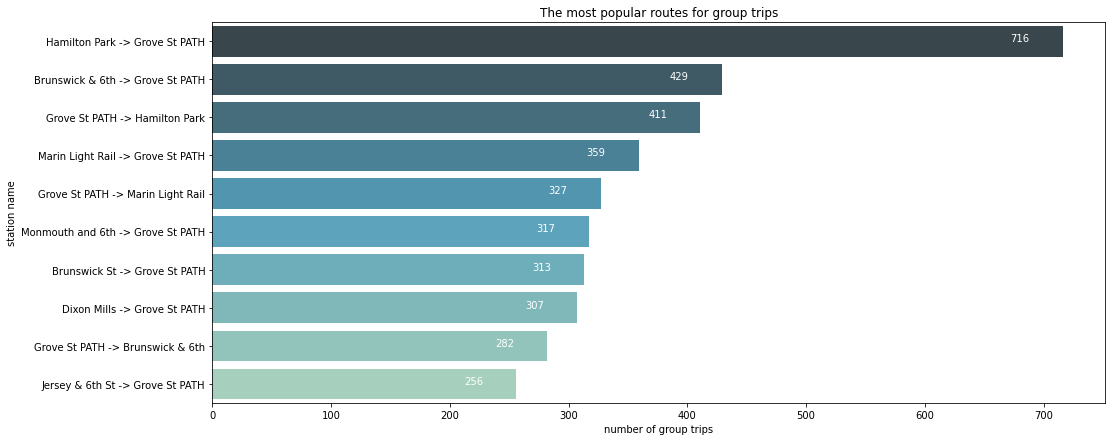

In [14]:
#popular routes

popular_routes = pd.DataFrame({'routes': groups['start station name'] + ' -> ' +  groups['end station name']})
popular_routes = popular_routes.groupby(['routes']).size().reset_index(name='counts')
popular_routes = popular_routes.sort_values(by=['counts'], ascending=False).head(10)

ax = sns.barplot(popular_routes['counts'], popular_routes['routes'], palette="GnBu_d")
ax.set_title('The most popular routes for group trips', fontsize = 12)
ax.set(xlabel='number of group trips', ylabel='station name')

rcParams['figure.figsize'] = 14,7

padding = 0.05 * popular_routes.counts.max()
for index, c in enumerate(popular_routes.counts):
    ax.text(c - padding, index, round(c, 1), 
            color='white', ha="center", fontsize = 10)

plt.show()

The most popular route for groups is Hamilton Park -> Grove St Path. There is High School located near Hamilton Park and Grove St Path appears to be the most attrictive place in Jersey Citi. This is seen very well on example below where we analyzing the most popular destination.

Here Grove St Path is also taking leadership. First of all because off the perfect location on this station, a lot of restaurants located there and also you can catch train to New York from there.

<img src = "bike_route.png" width = "50%" height = "40%">

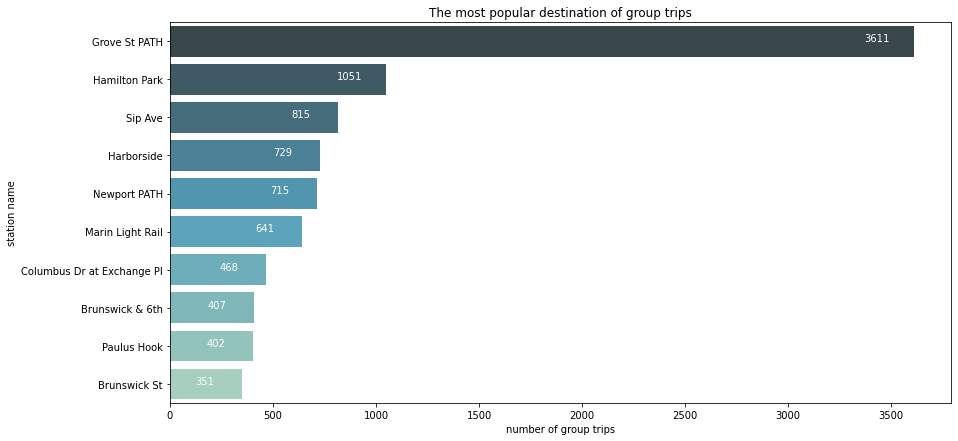

In [12]:
# popular end destination

popular_destination = groups.groupby(['end station name']).size().reset_index(name='counts')
popular_destination = popular_destination.sort_values(by=['counts'], ascending=False).head(10)

ax = sns.barplot(popular_destination['counts'], popular_destination['end station name'], palette="GnBu_d")
ax.set_title('The most popular destination of group trips', fontsize = 12)
ax.set(xlabel='number of group trips', ylabel='station name')

rcParams['figure.figsize'] = 14,7

padding = 0.05 * popular_destination.counts.max()
for index, c in enumerate(popular_destination.counts):
    ax.text(c - padding, index, round(c, 1), 
            color='white', ha="center", fontsize = 10)

plt.show()